In [347]:
import cv2
import os
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns


In [2]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    print(data)
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def all_zeros(lst):
    return all(v == 0.0 for v in lst)


In [5]:
def extract_features(data,sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(data, sample_rate):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    # data, sample_rate = librosa.load(path)
    
    # without augmentation
    res1 = extract_features(data,sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data,sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # # data with stretching and pitching
    # new_data = pitch(data)
    # data_stretch_pitch = pitch(new_data, sample_rate)
    # res3 = extract_features(data_stretch_pitch,sample_rate)
    # result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [6]:
def detect_and_crop_face(frame, face_cascade):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    cropped_faces = [gray[y:y+h, x:x+w] for (x, y, w, h) in faces]
    return cropped_faces

def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
actorsId = ["{:02}".format(i) for i in range(1, 25)]
comboFiles = ['01-01-01', '01-01-02', '01-02-01', '01-02-02',
              '02-01-01', '02-01-02', '02-02-01', '02-02-02']

data = []
data_1 = []
# data_2 = []
threshold = 400

for actor in actorsId:
    for emotion in range(1, 9):
        for file in comboFiles:
            try:
                path = f"Dataset/Actor_{actor}/01-01-0{emotion}-{file}-{actor}.mp4"
                audio, sr = librosa.load(path, sr=None)
                vedData = []

                cap = cv2.VideoCapture(path)
                frame_rate = cap.get(cv2.CAP_PROP_FPS)
                frame_count = 0
                ret, prev_frame = cap.read()
                cropped_faces = detect_and_crop_face(prev_frame, face_cascade)
                if len(cropped_faces) == 0:
                    prev_frame = np.zeros((128, 128))
                else:
                    prev_frame = cv2.resize(cropped_faces[0], (128, 128), interpolation=cv2.INTER_CUBIC)

                while cap.isOpened():
                    ret, current_frame = cap.read()
                    if not ret:
                        break
                    
                    cropped_frame = detect_and_crop_face(current_frame, face_cascade)
                    if len(cropped_faces) == 0:
                        current_frame = np.zeros((128, 128))
                    else:
                        current_frame = cv2.resize(
                            cropped_frame[0], (128, 128), interpolation=cv2.INTER_CUBIC)
                    error = mse(prev_frame, current_frame)
                    if error > threshold:
                        vedData.append(current_frame)
                        prev_frame = current_frame
                        frame_count += 1
                        # Calculating the audio segment for this frame
                        # start_sample = int(frame_count * sr / frame_rate)
                        # end_sample = int((frame_count + 1) * sr / frame_rate)
                        # audio_segment = y[start_sample:end_sample]
                        # if(all_zeros(audio_segment)!=True):

                metaData = file.split('-')

                features = get_features(audio, sr)
                regular_features, noise_features = features

                data.append({
                    "vid id":f"01-01-0{emotion}-{file}-{actor}",
                    "frame count": frame_count,
                    "frame": vedData,
                    "audio": audio,
                    "audio features": regular_features,
                    "actor": actor,
                    "emotion": emotion,
                    "emotional intensity": metaData[0],
                    "statement": metaData[1],
                    "repetition": metaData[2],
                    "noise":False
                })

                # Add the noise data
                data_1.append({
                    "vid id":f"01-01-0{emotion}-{file}-{actor}",
                    "frame count": frame_count,
                    "frame": vedData,
                    "audio": noise(audio),
                    "audio features": noise_features,
                    "actor": actor,
                    "emotion": emotion,
                    "emotional intensity": metaData[0],
                    "statement": metaData[1],
                    "repetition": metaData[2],
                    "noise":True
                })

                # # Add the stretched data
                # data_2.append({
                #     "frame count": frame_count,
                #     "frame": vedData,
                #     "audio": pitch(audio),
                #     "extracted_features": pitch_features,
                #     "actor": actor,
                #     "emotion": emotion,
                #     "Emotional intensity": metaData[0],
                #     "Statement": metaData[1],
                #     "Repetition": metaData[2]
                # })


            except Exception as e:
                print(f"Error processing {path}: {e}")

# Combine the lists and convert to a pandas dataframe
df = pd.DataFrame(data + data_1)


/var/folders/zj/hd8_xvbd3fvbp9wj5412cw_c0000gn/T/ipykernel_34363/2895913794.py:29: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(path, sr=None)


Error processing Dataset/Actor_01/01-01-01-02-01-01-01.mp4: [Errno 2] No such file or directory: 'Dataset/Actor_01/01-01-01-02-01-01-01.mp4'
Error processing Dataset/Actor_01/01-01-01-02-01-02-01.mp4: [Errno 2] No such file or directory: 'Dataset/Actor_01/01-01-01-02-01-02-01.mp4'
Error processing Dataset/Actor_01/01-01-01-02-02-01-01.mp4: [Errno 2] No such file or directory: 'Dataset/Actor_01/01-01-01-02-02-01-01.mp4'
Error processing Dataset/Actor_01/01-01-01-02-02-02-01.mp4: [Errno 2] No such file or directory: 'Dataset/Actor_01/01-01-01-02-02-02-01.mp4'
Error processing Dataset/Actor_02/01-01-01-02-01-01-02.mp4: [Errno 2] No such file or directory: 'Dataset/Actor_02/01-01-01-02-01-01-02.mp4'
Error processing Dataset/Actor_02/01-01-01-02-01-02-02.mp4: [Errno 2] No such file or directory: 'Dataset/Actor_02/01-01-01-02-01-02-02.mp4'
Error processing Dataset/Actor_02/01-01-01-02-02-01-02.mp4: [Errno 2] No such file or directory: 'Dataset/Actor_02/01-01-01-02-02-01-02.mp4'
Error process

In [7]:
df

,vid id,frame count,frame,audio,audio features,actor,emotion,emotional intensity,statement,repetition,noise
0,01-01-01-01-01-01-01,20,"[[[253, 253, 253, 253, 253, 253, 253, 252, 248...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.03567445816532258, 0.5097782611846924, 0.51...",01,1,01,01,01,False
1,01-01-01-01-01-02-01,25,"[[[253, 253, 253, 253, 253, 253, 253, 245, 57,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.03014197716346154, 0.5745578408241272, 0.60...",01,1,01,01,02,False
2,01-01-01-01-02-01-01,36,"[[[253, 253, 253, 253, 253, 253, 253, 253, 253...","[-3.0517578e-05, -3.0517578e-05, -3.0517578e-0...","[0.023743872549019607, 0.5791585445404053, 0.5...",01,1,01,02,01,False
3,01-01-01-01-02-02-01,33,"[[[253, 253, 253, 253, 253, 253, 253, 253, 250...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.031248361472315436, 0.6196701526641846, 0.6...",01,1,01,02,02,False
4,01-01-02-01-01-01-01,42,"[[[253, 253, 253, 253, 253, 253, 253, 253, 253...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02959690323795181, 0.4655737280845642, 0.50...",01,2,01,01,01,False
...,...,...,...,...,...,...,...,...,...,...,...
2857,01-01-08-01-02-02-24,26,"[[[253, 253, 253, 253, 253, 253, 252, 251, 113...","[-0.0014641701916311002, -0.002902263904920718...","[0.35516510009765623, 0.740570846496803, 0.728...",24,8,01,02,02,True
2858,01-01-08-02-01-01-24,46,"[[[192, 47, 36, 43, 30, 49, 63, 92, 68, 24, 55...","[0.003939510186264348, -0.00904217452127787, -...","[0.3132640941722973, 0.7502778458843761, 0.744...",24,8,02,01,01,True
2859,01-01-08-02-01-02-24,54,"[[[253, 253, 253, 253, 254, 195, 64, 39, 70, 6...","[2.3257136404176216e-07, 6.768440433886118e-06...","[0.3528606455813172, 0.76643062853518, 0.76175...",24,8,02,01,02,True
2860,01-01-08-02-02-01-24,65,"[[[253, 253, 253, 253, 253, 253, 255, 178, 50,...","[-0.0033075108402811407, -0.001899079927731205...","[0.32873393214026164, 0.7053188086127263, 0.71...",24,8,02,02,01,True


In [8]:
df['frame count'].max()

98

In [10]:
# Function to pad video frames to a fixed size
def pad_frames(vedData):
    frame_padding_amount = 100 - len(vedData)
    vedData.extend([np.zeros((128, 128)) for _ in range(frame_padding_amount)])
    return vedData

# Function to generate emotion label
def generate_label(row):
    label = np.zeros(8)  # 8 classes
    emotion_index = row['emotion'] - 1  # Assuming emotion ranges from 1 to 8, this makes it 0-indexed
    intensity_factor = 0.5 if row['emotional intensity'] == '01' else 1.0
    label[emotion_index] = intensity_factor
    return label

# Update the 'frame' column to have padded data
df['frame_pad'] = df['frame'].apply(pad_frames)

# Generate the labels and add as a new column 'emotion_label'
df['emotion_label'] = df.apply(generate_label, axis=1)


In [11]:
df

,vid id,frame count,frame,audio,audio features,actor,emotion,emotional intensity,statement,repetition,noise,frame_pad,emotion_label
0,01-01-01-01-01-01-01,20,"[[[253, 253, 253, 253, 253, 253, 253, 252, 248...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.03567445816532258, 0.5097782611846924, 0.51...",01,1,01,01,01,False,"[[[253, 253, 253, 253, 253, 253, 253, 252, 248...","[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,01-01-01-01-01-02-01,25,"[[[253, 253, 253, 253, 253, 253, 253, 245, 57,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.03014197716346154, 0.5745578408241272, 0.60...",01,1,01,01,02,False,"[[[253, 253, 253, 253, 253, 253, 253, 245, 57,...","[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,01-01-01-01-02-01-01,36,"[[[253, 253, 253, 253, 253, 253, 253, 253, 253...","[-3.0517578e-05, -3.0517578e-05, -3.0517578e-0...","[0.023743872549019607, 0.5791585445404053, 0.5...",01,1,01,02,01,False,"[[[253, 253, 253, 253, 253, 253, 253, 253, 253...","[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,01-01-01-01-02-02-01,33,"[[[253, 253, 253, 253, 253, 253, 253, 253, 250...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.031248361472315436, 0.6196701526641846, 0.6...",01,1,01,02,02,False,"[[[253, 253, 253, 253, 253, 253, 253, 253, 250...","[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,01-01-02-01-01-01-01,42,"[[[253, 253, 253, 253, 253, 253, 253, 253, 253...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02959690323795181, 0.4655737280845642, 0.50...",01,2,01,01,01,False,"[[[253, 253, 253, 253, 253, 253, 253, 253, 253...","[0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2857,01-01-08-01-02-02-24,26,"[[[253, 253, 253, 253, 253, 253, 252, 251, 113...","[-0.0014641701916311002, -0.002902263904920718...","[0.35516510009765623, 0.740570846496803, 0.728...",24,8,01,02,02,True,"[[[253, 253, 253, 253, 253, 253, 252, 251, 113...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5]"
2858,01-01-08-02-01-01-24,46,"[[[192, 47, 36, 43, 30, 49, 63, 92, 68, 24, 55...","[0.003939510186264348, -0.00904217452127787, -...","[0.3132640941722973, 0.7502778458843761, 0.744...",24,8,02,01,01,True,"[[[192, 47, 36, 43, 30, 49, 63, 92, 68, 24, 55...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
2859,01-01-08-02-01-02-24,54,"[[[253, 253, 253, 253, 254, 195, 64, 39, 70, 6...","[2.3257136404176216e-07, 6.768440433886118e-06...","[0.3528606455813172, 0.76643062853518, 0.76175...",24,8,02,01,02,True,"[[[253, 253, 253, 253, 254, 195, 64, 39, 70, 6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
2860,01-01-08-02-02-01-24,65,"[[[253, 253, 253, 253, 253, 253, 255, 178, 50,...","[-0.0033075108402811407, -0.001899079927731205...","[0.32873393214026164, 0.7053188086127263, 0.71...",24,8,02,02,01,True,"[[[253, 253, 253, 253, 253, 253, 255, 178, 50,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


In [12]:
df.to_pickle("aligned_data_1.pkl")

In [2]:
df = pd.read_pickle("aligned_data_1.pkl")

In [13]:
min_length = df['audio features'].apply(len).min()
max_length = df['audio features'].apply(len).max()

print("Minimum length:", min_length)
print("Maximum length:", max_length)

Minimum length: 162
Maximum length: 162


In [14]:
min_length = df['audio'].apply(len).min()
max_length = df['audio'].apply(len).max()

print("Minimum length:", min_length)
print("Maximum length:", max_length)

Minimum length: 141248
Maximum length: 252864


In [18]:
np.shape(df['frame_pad'][10])

(100, 128, 128)

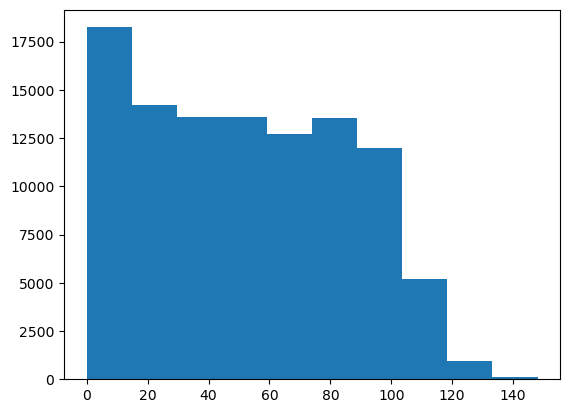

In [8]:
counts, bin_edges, _ = plt.hist(np.array(df['frame count']), bins=10)

In [10]:
bin_edges

array([  0. ,  14.8,  29.6,  44.4,  59.2,  74. ,  88.8, 103.6, 118.4,
       133.2, 148. ])

<Axes: ylabel='count'>

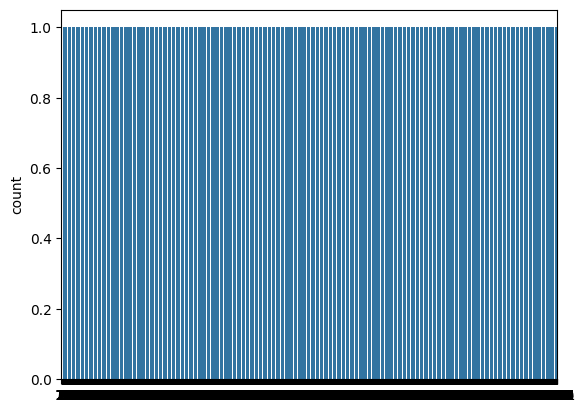

In [349]:
sns.countplot(df['emotion'])

In [70]:
# Split the dataframe based on the 'Repetition' column
df_01 = df[df['repetition'] == '01']
df_02 = df[df['repetition'] == '02']


In [71]:
df_01

,vid id,frame count,frame,audio,audio features,actor,emotion,emotional intensity,statement,repetition,noise,frame_pad,emotion_label
0,01-01-01-01-01-01-01,20,"[[[253, 253, 253, 253, 253, 253, 253, 252, 248...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.03567445816532258, 0.5097782611846924, 0.51...",01,1,01,01,01,False,"[[[253, 253, 253, 253, 253, 253, 253, 252, 248...","[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,01-01-01-01-02-01-01,36,"[[[253, 253, 253, 253, 253, 253, 253, 253, 253...","[-3.0517578e-05, -3.0517578e-05, -3.0517578e-0...","[0.023743872549019607, 0.5791585445404053, 0.5...",01,1,01,02,01,False,"[[[253, 253, 253, 253, 253, 253, 253, 253, 253...","[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,01-01-02-01-01-01-01,42,"[[[253, 253, 253, 253, 253, 253, 253, 253, 253...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02959690323795181, 0.4655737280845642, 0.50...",01,2,01,01,01,False,"[[[253, 253, 253, 253, 253, 253, 253, 253, 253...","[0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
6,01-01-02-01-02-01-01,38,"[[[253, 253, 253, 253, 253, 253, 253, 253, 252...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.030843595179115852, 0.47242289781570435, 0....",01,2,01,02,01,False,"[[[253, 253, 253, 253, 253, 253, 253, 253, 252...","[0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
8,01-01-02-02-01-01-01,27,"[[[253, 253, 253, 253, 253, 253, 253, 253, 253...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.024118006914511495, 0.4547256827354431, 0.4...",01,2,02,01,01,False,"[[[253, 253, 253, 253, 253, 253, 253, 253, 253...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2852,01-01-07-02-02-01-24,40,"[[[253, 253, 254, 253, 193, 111, 42, 50, 47, 7...","[-0.006024658518056709, 0.005122690013189679, ...","[0.33463705244974873, 0.7212775328735115, 0.72...",24,7,02,02,01,True,"[[[253, 253, 254, 253, 193, 111, 42, 50, 47, 7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2854,01-01-08-01-01-01-24,21,"[[[253, 253, 253, 253, 253, 253, 120, 33, 51, ...","[-6.779199015591339e-05, 3.07029769281923e-05,...","[0.38429782006048385, 0.8111734912059783, 0.80...",24,8,01,01,01,True,"[[[253, 253, 253, 253, 253, 253, 120, 33, 51, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5]"
2856,01-01-08-01-02-01-24,34,"[[[252, 252, 240, 147, 45, 38, 53, 58, 108, 18...","[-0.00040905234525304975, 3.10713648948316e-06...","[0.3221667325949367, 0.7213129183333424, 0.740...",24,8,01,02,01,True,"[[[252, 252, 240, 147, 45, 38, 53, 58, 108, 18...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5]"
2858,01-01-08-02-01-01-24,46,"[[[192, 47, 36, 43, 30, 49, 63, 92, 68, 24, 55...","[0.003939510186264348, -0.00904217452127787, -...","[0.3132640941722973, 0.7502778458843761, 0.744...",24,8,02,01,01,True,"[[[192, 47, 36, 43, 30, 49, 63, 92, 68, 24, 55...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


In [72]:
df_02

,vid id,frame count,frame,audio,audio features,actor,emotion,emotional intensity,statement,repetition,noise,frame_pad,emotion_label
1,01-01-01-01-01-02-01,25,"[[[253, 253, 253, 253, 253, 253, 253, 245, 57,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.03014197716346154, 0.5745578408241272, 0.60...",01,1,01,01,02,False,"[[[253, 253, 253, 253, 253, 253, 253, 245, 57,...","[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,01-01-01-01-02-02-01,33,"[[[253, 253, 253, 253, 253, 253, 253, 253, 250...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.031248361472315436, 0.6196701526641846, 0.6...",01,1,01,02,02,False,"[[[253, 253, 253, 253, 253, 253, 253, 253, 250...","[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
5,01-01-02-01-01-02-01,28,"[[[253, 253, 253, 253, 253, 253, 253, 253, 250...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.023239587185650886, 0.4291051924228668, 0.4...",01,2,01,01,02,False,"[[[253, 253, 253, 253, 253, 253, 253, 253, 250...","[0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
7,01-01-02-01-02-02-01,36,"[[[253, 253, 253, 253, 253, 253, 253, 251, 210...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02374305023006135, 0.5535850524902344, 0.58...",01,2,01,02,02,False,"[[[253, 253, 253, 253, 253, 253, 253, 251, 210...","[0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,01-01-02-02-01-02-01,40,"[[[253, 253, 253, 253, 253, 253, 253, 251, 236...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.03672887923869681, 0.46099087595939636, 0.4...",01,2,02,01,02,False,"[[[253, 253, 253, 253, 253, 253, 253, 251, 236...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,01-01-07-02-02-02-24,44,"[[[253, 253, 253, 253, 253, 243, 141, 44, 52, ...","[0.0016394067937712004, 0.0017700299748500531,...","[0.3350935715895433, 0.8033467486469459, 0.794...",24,7,02,02,02,True,"[[[253, 253, 253, 253, 253, 243, 141, 44, 52, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2855,01-01-08-01-01-02-24,34,"[[[253, 253, 253, 253, 253, 253, 253, 252, 235...","[0.0003984263557439364, 0.00032202150625305697...","[0.3108119847584356, 0.7258999225067347, 0.691...",24,8,01,01,02,True,"[[[253, 253, 253, 253, 253, 253, 253, 252, 235...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5]"
2857,01-01-08-01-02-02-24,26,"[[[253, 253, 253, 253, 253, 253, 252, 251, 113...","[-0.0014641701916311002, -0.002902263904920718...","[0.35516510009765623, 0.740570846496803, 0.728...",24,8,01,02,02,True,"[[[253, 253, 253, 253, 253, 253, 252, 251, 113...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5]"
2859,01-01-08-02-01-02-24,54,"[[[253, 253, 253, 253, 254, 195, 64, 39, 70, 6...","[2.3257136404176216e-07, 6.768440433886118e-06...","[0.3528606455813172, 0.76643062853518, 0.76175...",24,8,02,01,02,True,"[[[253, 253, 253, 253, 254, 195, 64, 39, 70, 6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


# Main Model
================================================================================================================================================================================
================================================================================================================================================================================

In [340]:
import tensorflow as tf


regularization_strength = 0.01

class Attention(tf.keras.layers.Layer):
    def __init__(self, in_dim_k, in_dim_q, out_dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super(Attention, self).__init__()
        
        self.num_heads = num_heads
        head_dim = out_dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # Define the layers
        self.q = tf.keras.layers.Dense(out_dim, use_bias=qkv_bias)
        self.kv = tf.keras.layers.Dense(out_dim * 2, use_bias=qkv_bias)
        self.attn_drop = tf.keras.layers.Dropout(attn_drop)
        self.proj = tf.keras.layers.Dense(out_dim)
        self.proj_drop = tf.keras.layers.Dropout(proj_drop)
        self.qkmatrix = None
        # self.post_attention_pooling = tf.keras.layers.MaxPooling1D(pool_size=2) 

    def call(self, inputs, training=False):
        x, x_q = inputs
        _, Nk, Ck = x.shape
        _, Nq, Cq = x_q.shape

        q = self.q(x_q)
        q = tf.reshape(q, [-1, Nq, self.num_heads, tf.shape(q)[-1]])
        q = tf.transpose(q, [0, 2, 1, 3])

        kv = self.kv(x)
        kv = tf.reshape(kv, [-1, Nk, 2, self.num_heads, tf.shape(kv)[-1] // 2])
        kv = tf.transpose(kv, [2, 0, 3, 1, 4])
        k, v = kv[0], kv[1]

        attn = tf.matmul(q, k, transpose_b=True) * self.scale
        attn = tf.nn.softmax(attn, axis=-1)
        
        self.qkmatrix = attn
        attn = self.attn_drop(attn)

        x = tf.matmul(attn, v)
        x = tf.transpose(x, [0, 2, 1, 3])
        x = tf.reshape(x, [-1, Nq, self.num_heads * tf.shape(x)[-1]])
        x = self.proj(x)
        x = self.proj_drop(x)
        # x = self.post_attention_pooling(x)

        return x, self.qkmatrix


# Video stages
def video_stage1(input_shape):
    video_input = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(video_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    shape = x.get_shape().as_list()
    x = tf.keras.layers.Reshape((shape[1]*shape[2], shape[3]))(x)
    x = tf.keras.layers.Conv1D(64, 3, activation='relu')(x)
    # x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Conv1D(64, 3, activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    return tf.keras.Model(inputs=video_input, outputs=x, name="video_stage1_model")

def video_stage2(input_shape_stage2):
    # Stage 2
    vedio_input_stage2 = tf.keras.layers.Input(shape=input_shape_stage2)
    x2 = tf.keras.layers.Conv1D(128, 3, activation='relu')(vedio_input_stage2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    # x2 = tf.keras.layers.MaxPooling1D(pool_size=2)(x2)
    x2 = tf.keras.layers.Conv1D(256, 3, activation='relu')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.MaxPooling1D(pool_size=2)(x2)
    x2 = tf.keras.layers.Dropout(0.3)(x2)
    return tf.keras.Model(inputs=vedio_input_stage2, outputs=x2, name="video_stage2_model")

def audio_stage1(input_shape):
    audio_input = tf.keras.layers.Input(shape=input_shape)
    # x = tf.keras.layers.Reshape((-1, 1))(audio_input)
    x = tf.keras.layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu')(audio_input)
    x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.MaxPooling1D(pool_size=5, strides=2, padding='same')(x)
    x = tf.keras.layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=5, strides=2, padding='same')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    return tf.keras.Model(inputs=audio_input, outputs=x, name="audio_stage1_model")

def audio_stage2(input_shape_stage2):
    audio_input_stage2 = tf.keras.layers.Input(shape=input_shape_stage2)
    x2 = tf.keras.layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu')(audio_input_stage2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    # x2 = tf.keras.layers.MaxPooling1D(pool_size=5, strides=2, padding='same')(x2)
    x2 = tf.keras.layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.MaxPooling1D(pool_size=5, strides=2, padding='same')(x2)
    x2 = tf.keras.layers.Dropout(0.3)(x2)
    return tf.keras.Model(inputs=audio_input_stage2, outputs=x2, name="audio_stage2_model")



class Model(tf.keras.Model):
    def __init__(self, video_input_shape, audio_input_shape, num_heads=1):
        super(Model, self).__init__()
        self.video_stage1 = video_stage1(video_input_shape)
        self.audio_stage1 = audio_stage1(audio_input_shape)



        # Getting the shapes after stage 1 transformations
        video_output_shape = self.video_stage1.layers[-1].output_shape[1:]
        audio_output_shape = self.audio_stage1.layers[-1].output_shape[1:]


        audio_output_shape_after_attention = (audio_output_shape[0], 64)
        vedio_output_shape_after_attention = (video_output_shape[0], 64)
        # audio_output_shape_after_attention = (video_output_shape[-1])
        # vedio_output_shape_after_attention = (audio_output_shape[-1])

        self.audio_stage2 = audio_stage2(audio_output_shape_after_attention)
        self.video_stage2 = video_stage2(vedio_output_shape_after_attention)

        self.av1 = Attention(in_dim_k=video_output_shape[-1], in_dim_q=audio_output_shape[-1], out_dim=audio_output_shape[-1], num_heads=num_heads)
        self.va1 = Attention(in_dim_k=audio_output_shape[-1], in_dim_q=video_output_shape[-1], out_dim=video_output_shape[-1], num_heads=num_heads)

        self.final_mlp_layer_1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_strength))
        self.final_mlp_layer_output = tf.keras.layers.Dense(8, activation='softmax', name="final_classification")
        self.batch_normalization = tf.keras.layers.BatchNormalization()

    def call(self,inputs, training=False):
        x_audio, x_visual = inputs
        x_audio = self.audio_stage1(x_audio)
        x_visual = self.video_stage1(x_visual)

        proj_x_a = tf.transpose(x_audio, perm=[0,2,1])
        proj_x_v = tf.transpose(x_visual, perm=[0,2,1])

        _, h_av = self.av1((proj_x_v, proj_x_a))
        _, h_va = self.va1((proj_x_a, proj_x_v))

        if h_av.shape[1] > 1:  # if more than 1 head, take average
            h_av = tf.reduce_mean(h_av, axis=1, keepdims=True)

        if h_va.shape[1] > 1:  # if more than 1 head, take average
            h_va = tf.reduce_mean(h_va, axis=1, keepdims=True)

        h_av = tf.reduce_sum(h_av, axis=-2)
        h_va = tf.reduce_sum(h_va, axis=-2)

        x_audio = h_va + x_audio
        x_visual = h_av + x_visual
        
        # Passing through stage 2
        x_audio = self.audio_stage2(x_audio)
        x_visual = self.video_stage2(x_visual)
        flat_audio = tf.keras.layers.Flatten()(x_audio)
        flat_video = tf.keras.layers.Flatten()(x_visual)

        combined = tf.keras.layers.concatenate([flat_audio, flat_video])
        hidden = self.final_mlp_layer_1(combined)
        hidden = self.batch_normalization(hidden)
        hidden = tf.keras.layers.Dropout(0.3)(hidden)
        sentiment = self.final_mlp_layer_output(hidden)
        
        return sentiment

model = Model(video_input_shape=(100, 128, 128), audio_input_shape=(162,1))
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Create dummy data
dummy_audio_data = tf.random.normal([1, *model.audio_stage1.input_shape[1:]])
dummy_video_data = tf.random.normal([1, *model.video_stage1.input_shape[1:]])

# Pass the dummy data through the model
_ = model([dummy_audio_data, dummy_video_data])

# Now you can view the summary
model.summary()


Model: "model_127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 video_stage1_model (Functi  (None, 1542, 64)          86656     
 onal)                                                           
                                                                 
 audio_stage1_model (Functi  (None, 81, 64)            21440     
 onal)                                                           
                                                                 
 audio_stage2_model (Functi  (None, 41, 256)           206720    
 onal)                                                           
                                                                 
 video_stage2_model (Functi  (None, 769, 256)          124800    
 onal)                                                           
                                                                 
 attention_220 (Attention)   multiple                  20

In [235]:
dummy_audio_data = tf.random.normal([1, *model.audio_stage1.input_shape[1:]])
dummy_video_data = tf.random.normal([1, *model.video_stage1.input_shape[1:]])

# Debug each part of your model step by step
audio_out = model.audio_stage1(dummy_audio_data)
video_out = model.video_stage1(dummy_video_data)

print("Audio stage 1 output shape:", audio_out.shape)
print("Video stage 1 output shape:", video_out.shape)

# Continue this way for the rest of your architecture


Audio stage 1 output shape: (1, 41, 64)
Video stage 1 output shape: (1, 770, 64)


In [82]:
df[['audio features', 'frame']]

,audio features,frame
0,"[0.03567445816532258, 0.5097782611846924, 0.51...","[[[253, 253, 253, 253, 253, 253, 253, 252, 248..."
1,"[0.03014197716346154, 0.5745578408241272, 0.60...","[[[253, 253, 253, 253, 253, 253, 253, 245, 57,..."
2,"[0.023743872549019607, 0.5791585445404053, 0.5...","[[[253, 253, 253, 253, 253, 253, 253, 253, 253..."
3,"[0.031248361472315436, 0.6196701526641846, 0.6...","[[[253, 253, 253, 253, 253, 253, 253, 253, 250..."
4,"[0.02959690323795181, 0.4655737280845642, 0.50...","[[[253, 253, 253, 253, 253, 253, 253, 253, 253..."
...,...,...
2857,"[0.35516510009765623, 0.740570846496803, 0.728...","[[[253, 253, 253, 253, 253, 253, 252, 251, 113..."
2858,"[0.3132640941722973, 0.7502778458843761, 0.744...","[[[192, 47, 36, 43, 30, 49, 63, 92, 68, 24, 55..."
2859,"[0.3528606455813172, 0.76643062853518, 0.76175...","[[[253, 253, 253, 253, 254, 195, 64, 39, 70, 6..."
2860,"[0.32873393214026164, 0.7053188086127263, 0.71...","[[[253, 253, 253, 253, 253, 253, 255, 178, 50,..."


In [183]:
np.shape(df_01['audio features'][6])

(162,)

In [184]:
X_video_train = np.stack(df_01['frame_pad'].to_numpy())
X_audio_train = np.stack(df_01['audio features'].to_numpy())
y_labels_train = df_01['emotion_label'].to_numpy()

In [185]:
X_video = np.stack(df_02['frame_pad'].to_numpy())
X_audio = np.stack(df_02['audio features'].to_numpy())
y_labels = df_02['emotion_label'].to_numpy()

In [186]:
X_video_val, X_video_test, X_audio_val, X_audio_test, y_val, y_test = train_test_split(X_video, X_audio, y_labels, test_size=0.5, random_state=42)

In [187]:
y_labels_train = np.array([np.array(x) for x in y_labels_train], dtype='float32')
y_val = np.array([np.array(x) for x in y_val], dtype='float32')
y_test = np.array([np.array(x) for x in y_test], dtype='float32')

In [188]:
X_audio_train = X_audio_train.astype('float32')
X_video_train = X_video_train.astype('float32')
X_audio_val = X_audio_val.astype('float32')
X_video_val = X_video_val.astype('float32')
X_audio_test = X_audio_test.astype('float32')
X_video_test = X_video_test.astype('float32')

In [189]:
X_audio_train_reshape = tf.expand_dims(X_audio_train, axis=-1)
X_audio_val_reshape = tf.expand_dims(X_audio_val, axis=-1)
X_audio_test_reshape = tf.expand_dims(X_audio_test, axis=-1)

In [190]:
X_audio_train.shape

(1432, 162)

In [191]:
X_audio_train_reshape.shape

TensorShape([1432, 162, 1])

In [192]:
X_video_train.shape

(1432, 100, 128, 128)

In [193]:
y_labels_train.shape

(1432, 8)

In [341]:
history = model.fit([X_audio_train_reshape, X_video_train], y_labels_train, epochs=100, validation_data=([X_audio_val_reshape, X_video_val], y_val))


Epoch 1/100


2023-10-27 08:47:22.690202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - ETA: 0s - loss: 4.3917 - accuracy: 0.1872

2023-10-27 08:48:27.249030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - 82s 1s/step - loss: 4.3917 - accuracy: 0.1872 - val_loss: 4.1242 - val_accuracy: 0.1413
Epoch 2/100
45/45 [==============================] - 16s 342ms/step - loss: 3.7774 - accuracy: 0.1969 - val_loss: 3.5135 - val_accuracy: 0.1706
Epoch 3/100
45/45 [==============================] - 14s 319ms/step - loss: 3.2991 - accuracy: 0.2318 - val_loss: 3.1450 - val_accuracy: 0.2112
Epoch 4/100
45/45 [==============================] - 14s 311ms/step - loss: 2.9297 - accuracy: 0.2360 - val_loss: 2.9248 - val_accuracy: 0.1664
Epoch 5/100
45/45 [==============================] - 14s 313ms/step - loss: 2.7334 - accuracy: 0.2381 - val_loss: 2.6664 - val_accuracy: 0.1762
Epoch 6/100
45/45 [==============================] - 14s 309ms/step - loss: 2.4721 - accuracy: 0.2563 - val_loss: 2.4898 - val_accuracy: 0.1594
Epoch 7/100
45/45 [==============================] - 14s 321ms/step - loss: 2.3209 - accuracy: 0.2388 - val_loss: 2.4244 - val_accuracy: 0.1580
Epoch 8

In [343]:
history_1 = model.fit([X_audio_train_reshape, X_video_train], y_labels_train, epochs=100, validation_data=([X_audio_val_reshape, X_video_val], y_val))

Epoch 1/100
45/45 [==============================] - 18s 393ms/step - loss: 1.7114 - accuracy: 0.3610 - val_loss: 1.9017 - val_accuracy: 0.2811
Epoch 2/100
45/45 [==============================] - 15s 334ms/step - loss: 1.7143 - accuracy: 0.3652 - val_loss: 1.8443 - val_accuracy: 0.2741
Epoch 3/100
45/45 [==============================] - 14s 308ms/step - loss: 1.7042 - accuracy: 0.3771 - val_loss: 1.9747 - val_accuracy: 0.3203
Epoch 4/100
45/45 [==============================] - 14s 307ms/step - loss: 1.7437 - accuracy: 0.3757 - val_loss: 1.8922 - val_accuracy: 0.2741
Epoch 5/100
45/45 [==============================] - 13s 297ms/step - loss: 1.7356 - accuracy: 0.3645 - val_loss: 1.9787 - val_accuracy: 0.2965
Epoch 6/100
45/45 [==============================] - 14s 302ms/step - loss: 1.7077 - accuracy: 0.3778 - val_loss: 1.8619 - val_accuracy: 0.2993
Epoch 7/100
45/45 [==============================] - 13s 301ms/step - loss: 1.7332 - accuracy: 0.3652 - val_loss: 2.0108 - val_accuracy:

In [147]:
print(tf.__version__)

2.13.0


In [111]:
print(X_audio_train.shape)
print(X_video_train.shape)


(1432, 162)
(1432, 100, 128, 128)


In [210]:
history.history['val_loss']

[504.9491271972656,
 21624.904296875,
 431749.875,
 3335956.0,
 17910960.0,
 653477760.0,
 16562177024.0,
 260297687040.0,
 1214495719424.0,
 2055744782336.0,
 8088168955904.0,
 18676763852800.0,
 54135239999488.0,
 117497353207808.0,
 108793417433088.0,
 146623841697792.0,
 280453361696768.0,
 499845643108352.0,
 670112138919936.0,
 1311818437885952.0]

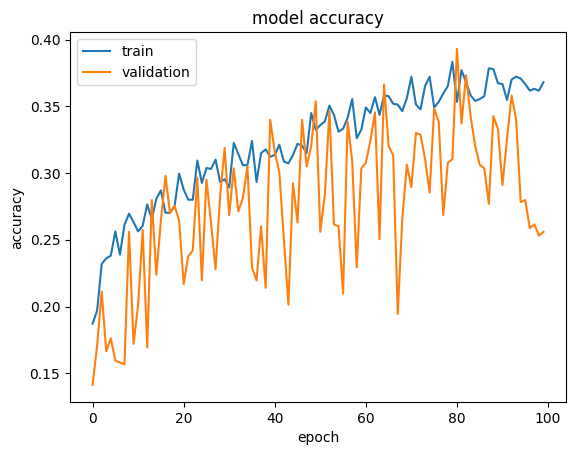

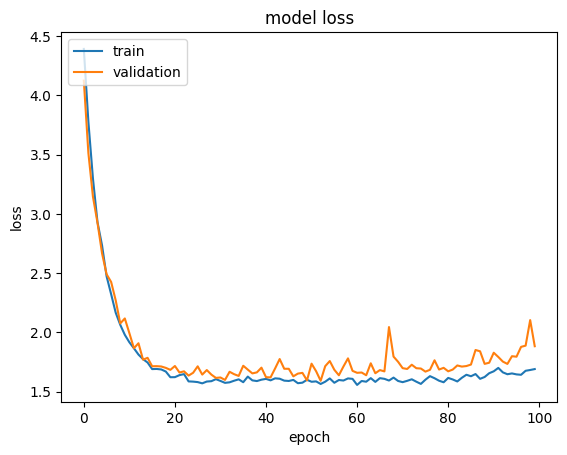

In [344]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


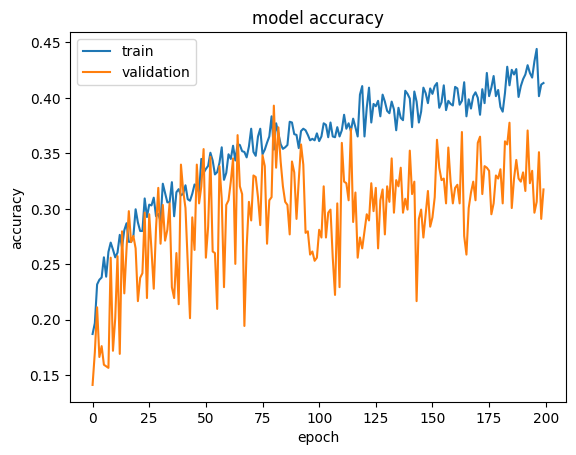

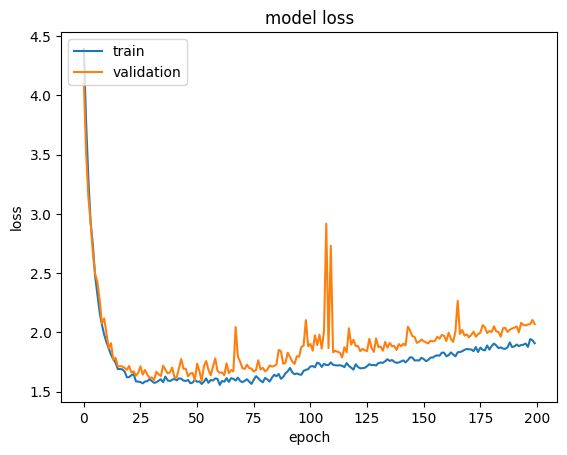

In [345]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history.history['accuracy']+history_1.history['accuracy'])
plt.plot(history.history['val_accuracy']+history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss']+history_1.history['loss'])
plt.plot(history.history['val_loss']+history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [346]:
# Assuming you have already prepared your test set in the same way as your training set
# padded_audios_test and padded_videos_test are the audio and video data of your test set
# labels_test are the true labels of your test set

# Predict the emotions on test data
predictions = model.predict([X_audio_test_reshape, X_video_test])
predicted_labels = np.argmax(predictions, axis=1)

# If your labels_test are not one-hot encoded, skip this line
true_labels = np.argmax(y_test, axis=1)

# Evaluate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Model Accuracy on Test Set: {accuracy * 100:.2f}%')


2023-10-27 09:39:31.593803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 11s 224ms/step
Model Accuracy on Test Set: 31.61%


In [330]:
X_audio_test.shape

(715, 162)

In [328]:
X_audio_test_reshape.shape

TensorShape([715, 162, 1])

In [335]:
X_audio_test[0].shape

(162,)

In [336]:
X_audio_test_reshape[0].shape

TensorShape([162, 1])

In [329]:
X_video_test.shape

(715, 100, 128, 128)

In [ ]:
# Assuming you have already prepared your test set in the same way as your training set
# padded_audios_test and padded_videos_test are the audio and video data of your test set
# labels_test are the true labels of your test set

# Predict the emotions on test data
predictions = model.predict([X_audio_test_reshape, X_video_test])
predicted_labels = np.argmax(predictions, axis=1)

# If your labels_test are not one-hot encoded, skip this line
true_labels = np.argmax(y_test, axis=1)

# Evaluate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Model Accuracy on Test Set: {accuracy * 100:.2f}%')


In [350]:
model.save_weights("SentimentAnalasys_v2.h5")

In [ ]:
# new_model.load_weights("SentimentAnalasys_v2.h5")